In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lenstronomy.LensModel.Profiles.gauss_decomposition import SersicEllipseGaussDec
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
import scipy.optimize as opt
from astropy.io import fits

In [2]:
def theta_E_S(c, m=1e13, z_lens=0.2, z_source=6.0, k=.1):
    factor=1.5*m/1e13
    lens_model = LensModel(['NFW', 'SERSIC_ELLIPSE_GAUSS_DEC'], z_lens=z_lens, z_source=z_source)
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)
#     print(Rs_angle, alpha_Rs)
    return opt.root(lambda x: lens_model.alpha(x,0, [{'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 0., 'center_y': 0.}, 
                {'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'k_eff':k, 'center_x': 0., 'center_y': 0.}])[0]-x, 1).x[0]


In [3]:
masses1 = np.load("data/halo_masses.npy")
params1 = np.load("data/halo_params.npy", allow_pickle=True)
zs1 = np.load("data/halo_zs.npy")
Rs1 = np.array([d['Rs'] for d in params1])
alpha_Rs1 = np.array([d['alpha_Rs'] for d in params1])
concs1 = np.load("data/c.npy")

masses2 = np.load("data/halo_masses2.npy")
params2 = np.load("data/halo_params2.npy", allow_pickle=True)
zs2 = np.load("data/halo_zs2.npy")
Rs2 = np.array([d['Rs'] for d in params2])
alpha_Rs2 = np.array([d['alpha_Rs'] for d in params2])
concs2 = np.load("data/c2.npy")

masses = np.concatenate([masses1, masses2])
params = np.concatenate([params1, params2])
zs = np.concatenate([zs1, zs2])
Rs = np.concatenate([Rs1, Rs2])
alpha_Rs = np.concatenate([alpha_Rs1, alpha_Rs2])
concs = np.concatenate([concs1, concs2])

masses = masses2
params = params2
zs = zs2
Rs = Rs2
alpha_Rs = alpha_Rs2
concs = concs2

# masses2, zs2, Rs2, alpha_Rs2

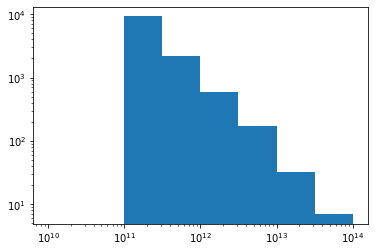

In [4]:
plt.hist(masses, log=True, bins=np.logspace(10,14,9))
plt.xscale('log')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 

(array([1.2113e+04, 2.8000e+01, 1.0000e+01, 5.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([-8.54733567e-321,  4.52895043e-001,  9.05790087e-001,
         1.35868513e+000,  1.81158017e+000,  2.26447522e+000,
         2.71737026e+000,  3.17026530e+000,  3.62316035e+000,
         4.07605539e+000,  4.52895043e+000]),
 <BarContainer object of 10 artists>)

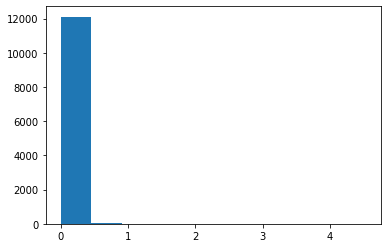

In [5]:
wc_thetaE = np.array([])
for i in range(len(masses2)):
    if i%100==0:
        print(i, end=" ")
    c = concs2[i]
    k = c*.01*(masses2[i]/1e13)**(1/3)*(np.log10(masses2[i])-9)/(13-9)
    te = theta_E_S(c, m=masses2[i], z_lens=zs2[i], z_source=4.0, k=k)
    wc_thetaE = np.append(wc_thetaE, te)
plt.hist(wc_thetaE)

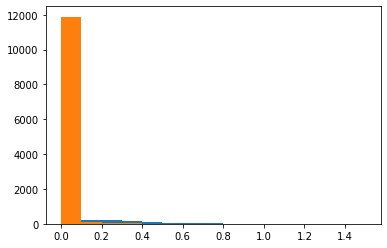

In [10]:
c_sig = np.load("/Users/ethansilver/Downloads/LensPop/lens_sig.npy", encoding="latin1",allow_pickle=True)
c_z = np.load("/Users/ethansilver/Downloads/LensPop/lens_z.npy", encoding="latin1",allow_pickle=True)
c_thetaE = np.array([])
for i in range(len(c_sig)):
    lens_cosmo = LensCosmo(c_z[i],4)
    te = lens_cosmo.sis_sigma_v2theta_E(c_sig[i])
    c_thetaE = np.append(c_thetaE, te)

bins = np.arange(0,1.6,0.1)
    
n, bins, _ = plt.hist(c_thetaE, bins=bins)
n2, bins, _ = plt.hist(wc_thetaE, bins=bins)

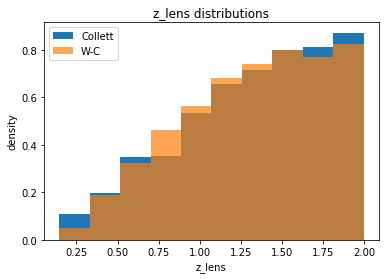

In [11]:
nz, binsz, _ = plt.hist(c_z, density=True, label="Collett")
plt.hist(zs2, density=True, alpha=0.7, label="W-C", bins=binsz)
plt.title("z_lens distributions")
plt.xlabel("z_lens")
plt.ylabel("density")
plt.legend()

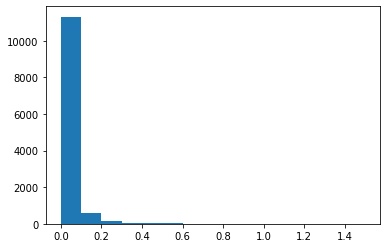

In [12]:
alpha = 0.16
beta = 3.31
z_sig = 100*10**((np.log10(masses2/1e12)-alpha)/beta)
z_thetaE = np.array([])
for i in range(len(z_sig)):
    lens_cosmo = LensCosmo(zs2[i],4)
    te = lens_cosmo.sis_sigma_v2theta_E(z_sig[i])
    z_thetaE = np.append(z_thetaE, te)
n3, bins, _ = plt.hist(z_thetaE, bins=bins)

Text(0, 0.5, "Count in 11'x11'")

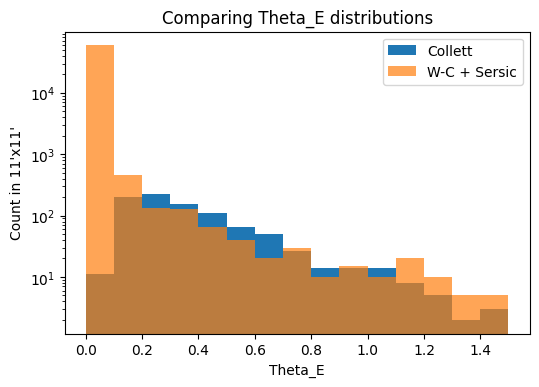

In [28]:
plt.figure(dpi=100)
plt.bar((bins[1:]+bins[:-1])/2, n, width=.1, log=True, label="Collett")
# plt.bar((bins[1:]+bins[:-1])/2, n3*5, width=.1, alpha=0.7, log=True, label="W-C to $\sigma$")
plt.bar((bins[1:]+bins[:-1])/2, n2*5, width=.1, alpha=0.7, log=True, label="W-C + Sersic")

plt.title("Comparing Theta_E distributions")
plt.legend()
plt.xlabel("Theta_E")
plt.ylabel("Count in 11'x11'")

In [5]:
with fits.open('/Users/ethansilver/Downloads/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    data = hdul[1].data
    header = hdul[1].header
data = data[data['RA']>53.165]
data = data[data['RA']<53.21]
data = data[data['DEC']<-27.75]
data = data[data['DEC']>-27.835]
total_source_area = (53.21-53.165)*(-27.75+27.835)*(3600**2)/.03**2 #pixels

z_sources = np.logspace(np.log10(max(data['redshift'])), np.log10(min(data['redshift'])), 20)
z_source_means = (z_sources[1:]+z_sources[:-1])/2

In [6]:
with fits.open('/Users/ethansilver/Downloads/goods_s_F115W_2018_08_29.fits') as hdul:
    data3 = hdul[0].data
    header3 = hdul[0].header
from astropy.wcs import WCS
w = WCS(header3)
from astropy.coordinates import SkyCoord
bkg = data3[5000:5050,8000:8050]
bkg = np.std(bkg)
bkg

0.0020595375

In [ ]:
TES=[]
lens_areas = np.ones(len(z_source_means))
source_areas = np.zeros(len(z_source_means))
net = np.ones(len(z_source_means))
counts = np.ones(len(z_source_means))
NORM = 1

# z_source_means = [6.0]
for zi in range(len(z_source_means)):
    print(zi, end=" ")
    sources = data[data['redshift']<z_sources[zi]]
    sources = sources[sources['redshift']>z_sources[zi+1]]
    print(len(sources))
    for source in range(len(sources)):
        R = int(sources[source]['Re_maj']/.03*3)
        ra, dec = sources[source]['RA'], sources[source]['DEC']
        sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
        x, y = w.world_to_pixel(sky)
        x, y = int(x), int(y)
        gal = data3[y-R:y+R,x-R:x+R]
        
        source_areas[zi] += np.count_nonzero([gal>5*bkg])/total_source_area
        

    TESz = []
    for lens in range(len(masses)):
        if zs[lens] < z_source_means[zi]:
#             lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=6.0)
#             _, _, c, _, _ = lens_cosmo.nfw_angle2physical(Rs[lens], alpha_Rs[lens])
            c = concs[lens]
            k = c*.01*(masses[lens]/1e13)**(1/3)*(np.log10(masses[lens])-9)/(13-9)
            theta_E = theta_E_S(c, m=masses[lens], z_lens=zs[lens], z_source=z_source_means[zi], k=k)
            TESz.append(theta_E)
        else:
            TESz.append(0)
    TESz = np.array(TESz)
#     TESz = TESz[TESz>.03]
    lens_areas[zi] = np.sum(np.pi * TESz**2)*NORM/(11*60)**2
    TES.append(TESz)
    net[zi] = lens_areas[zi] * source_areas[zi]
    counts[zi] = len(TESz[TESz>.03])*NORM/(11*60)**2 * source_areas[zi] #per square arcsecond


0 44
1 304
2 1266
3 2235
4 3027
5 3389
6 3412
7 3193
8 3018


all: 25 9.931382051851004e-06


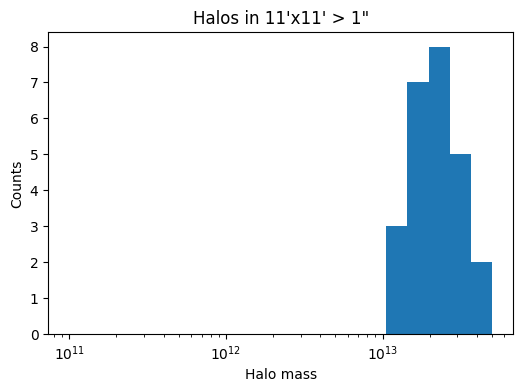

In [71]:
te = 1
print("all:",sum(TES[6]>te), sum(counts))
plt.figure(dpi=100)
plt.hist(masses[TES[6]>te], bins=np.logspace(11,np.log10(5e13),21))
plt.xscale('log')
plt.xlabel("Halo mass")
plt.ylabel("Counts")
plt.title("Halos in 11'x11' > "+str(te)+"\"");

In [35]:
np.mean(source_areas)

0.0009590652830332478

Text(0.5, 0, 'theta_E')

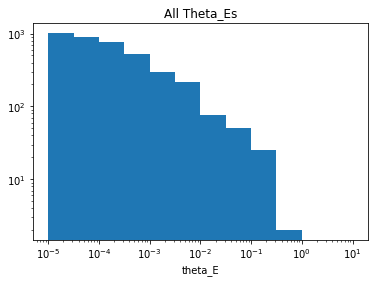

In [102]:
all_TES = []
all_masses = []
for i in range(len(TES)):
    for j in range(len(TES[i])):
        all_TES.append(TES[i][j])
        all_masses.append(masses[j])
plt.hist(all_TES, bins=np.logspace(-5,1,13), log=True)
plt.xscale('log')
plt.title("All Theta_Es")
plt.xlabel("theta_E")

In [101]:
max(all_TES)

0.32907193515925925

In [ ]:
plt.hist(all_TES[all_masses], bins=np.logspace(-5,1,13), log=True)

In [44]:
sum(np.array(all_TES)>.03)

78

In [73]:
max(masses)

3846221173235.5254

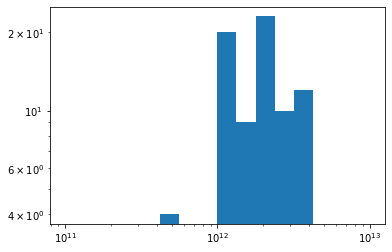

In [106]:
observed = np.array([])
for i in range(len(TES)):
    observed = np.concatenate([observed, masses[TES[i]>.03]])
plt.hist(observed, bins=np.logspace(11,13,17), log=True)
plt.xscale('log')
# ind = np.argmax(TES[4]*(masses<1e10))
# TES[4][ind]

(array([2.010e+03, 3.752e+03, 1.375e+03, 3.610e+02, 1.140e+02, 3.400e+01,
        1.400e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([0.0643937 , 0.21339375, 0.3623938 , 0.51139385, 0.6603939 ,
        0.80939395, 0.958394  , 1.10739405, 1.2563941 , 1.40539415,
        1.5543942 ]),
 <BarContainer object of 10 artists>)

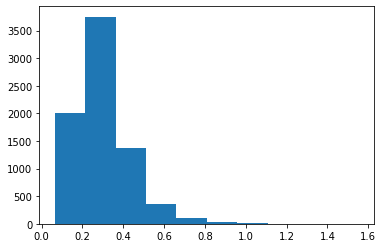

In [47]:
plt.hist(Rs[masses<1e10])

In [48]:
masses[ind]/1e9, params[ind], zs[ind], Rs[ind], alpha_Rs[ind]

(2.1184794735030867,
 {'alpha_Rs': 0.009204408900330238,
  'Rs': 0.07736353748801965,
  'center_x': -0.15857290734689333,
  'center_y': -0.24718894878514244},
 1.1649999999999998,
 0.07736353748801965,
 0.009204408900330238)

In [49]:
lens_cosmo = LensCosmo(z_lens=zs[ind], z_source=6.0)
_, _, c, _, m200 = lens_cosmo.nfw_angle2physical(Rs[ind], alpha_Rs[ind])
c, m200

(array(815.24209903), 62638341282174.375)

In [50]:
lens_cosmo.nfw_physical2angle(M=27310498511202.54, c=334.89)

(0.14280734066814002, 31.220427083397308)

In [51]:
params[0]

{'alpha_Rs': 0.005018058573713431,
 'Rs': 0.564213779160085,
 'center_x': 0.33606541452970606,
 'center_y': 0.6566926291526087}

In [125]:
len(TES[6][TES[6]>.03])*100

600

In [124]:
for i in range(len(TES)):
    print(z_source_means[i], len(TES[i][TES[i]>.03])*100)

12.538578966917417 800
10.030672675593202 800
8.0243857450162 800
6.4193866819616066 800
5.1354118161804365 700
4.108251430915027 600
3.2865387282939498 600
2.6291810504329916 600
2.103304895343276 600
1.682611960879009 400
1.3460640048722143 300
1.0768307532213672 300
0.8614482423466763 200
0.6891455059415672 200
0.5513059346034789 100
0.4410363717220357 0
0.3528223967362861 0
0.2822525569777574 0
0.2257977573346292 0


In [53]:
all_TES = np.array(TES[10])
len(all_TES[all_TES>.03])*100

300

In [20]:
areas = np.ones(len(z_source_means))
total = 0
for i in range(len(TES)):
    print(max(TES[i]))
    total += len(TES[i][TES[i]>.03])*100/(11*60)**2 * source_areas[i]
    TES[i] = TES[i][TES[i]<1]
    areas[i] = np.sum(np.pi * TES[i]**2)*100/(11*60)**2
total

5.002865777183724
4.940613071313626
4.866695272710784
4.778516189280985
4.672862746458385
4.545802925253139
4.392626788974274
4.207901849474825
3.9857620450296127
3.7205969917292165
3.408314469716689
3.048253950453292
2.8052920637573693
2.5350226662555846
1.366565615687252
1.2403709205976878
1.1665510328403905
1.0816241920654486
0.9861290852419544


0.0009931382051850998

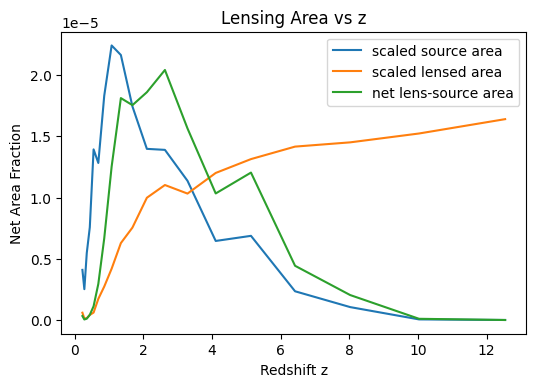

In [31]:
plt.figure(dpi=100)
plt.plot(z_source_means, source_areas/150*1.5, label="scaled source area")
plt.plot(z_source_means, areas/2000*1.5, label="scaled lensed area")
plt.plot(z_source_means, source_areas*areas, label="net lens-source area")
plt.legend()
plt.xlabel('Redshift z')
plt.ylabel("Net Area Fraction")
# plt.xlim(0,14)
plt.title('Lensing Area vs z');

In [22]:
source_areas

array([1.81554103e-08, 4.82933914e-06, 1.05355846e-04, 2.34531590e-04,
       6.87164125e-04, 6.45424837e-04, 1.13660131e-03, 1.38919753e-03,
       1.39744009e-03, 1.74386347e-03, 2.16368918e-03, 2.24184822e-03,
       1.83119099e-03, 1.28215323e-03, 1.39328250e-03, 7.57425563e-04,
       5.47240378e-04, 2.51724764e-04, 4.09259259e-04])

In [23]:
np.sum(source_areas)*100, np.mean(areas), np.sum(source_areas)*np.mean(areas)*100

(1.8222240377631709, 0.009903821642754511, 0.018046981863146405)

In [24]:
np.sum(counts)

9.931382051851005e-06

In [25]:
np.sum(source_areas*areas), np.sum(counts)*(3600**2)*41253/1e6

(0.0001434186126986575, 5.309702977053723)

In [26]:
np.sum(counts)*((60*11)**2)

4.326110021786298

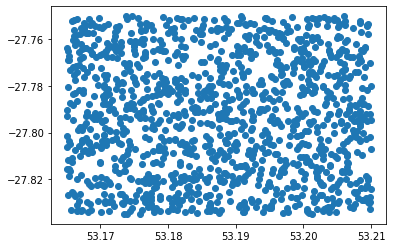

In [168]:
for pi in range(len(params)):
    params[pi]['center_x']=np.random.random()*(53.21-53.165)+53.165
    params[pi]['center_y']=np.random.random()*(27.835-27.75)-27.835
    
plt.scatter([pi['center_x'] for pi in params], [pi['center_y'] for pi in params])

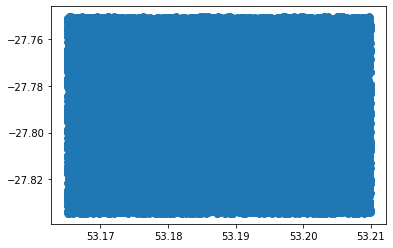

In [169]:
plt.scatter(data['RA'], data['DEC'])

In [170]:
source_ra = data['RA']
source_dec = data['DEC']
Re_maj = data['Re_maj']
source_z = data['redshift']

In [232]:


total = 0

for lens in range(len(masses)):
    if lens % 100==0:
        print(lens, end=" ")
    c = concs[lens]
    k = c*.01*(masses[lens]/1e13)**(1/3)*(np.log10(masses[lens])-9)/(13-9)
    theta_E = theta_E_S(c, m=masses[lens], z_lens=zs[lens], z_source=14, k=k)
    if theta_E>.03:
        
        raL, decL = params[lens]['center_x'], params[lens]['center_y']
        sources = data[(abs(source_ra-raL)<3*Re_maj/3600) * (abs(source_dec-decL)<3*Re_maj/3600)* (source_z>zs[lens])]
        for source in sources:
            ra, dec = source['RA'], source['DEC']
            sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
            x, y = w.world_to_pixel(sky)
            xS, yS = int(x), int(y)

            sky = SkyCoord(str(raL)+"d "+str(decL)+"d")
            x, y = w.world_to_pixel(sky)
            xL, yL = int(x), int(y)
    #         gal = data3[y-R:y+R,x-R:x+R]
            if data3[xS,yS]>5*bkg and data3[xL,yL]>5*bkg:
                theta_E = theta_E_S(c, m=masses[lens], z_lens=zs[lens], z_source=source['redshift'], k=k)
                if theta_E>.03:
                    total += 1
total

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 

1

In [233]:
data[0]['RA']

53.178176

In [234]:
len(data[(abs(source_ra-raL)<3*Re_maj/3600) * (abs(source_dec-decL)<3*Re_maj/3600)* (source_z>zs[lens])])

0

In [224]:
sources

(181608, 53.196571, -27.765447, 3.184432, 9.198083, -19.607502623484447, -1.6608716952928653, 0.62070423, 0.61188626, -8.586197, 10.516938, 9.025517, 0.2283072, 0.62435657, 62.583405, 145.08835, 153.22424, 154.11308, 156.7934, 162.52362, 176.0871, 213.67696, 264.13004, 362.82895, 383.18152, 150.62149, 157.14636, 167.48949, 247.44264, 360.72845, 414.2512, 368.85236, 389.0453, 189.94894, 337.12875, 327.9345, 402.637, 342.95438, 361.51352, 353.71274, 363.85498, 400.4362, 377.73773, 402.3401, 359.62277, 393.35245, -0.569586, 8.150947, -0.22977047071279563, -0.012482839102374072, 0.16426517597334897, 2.6113360689333147, 133.05703213836742, 34.38883383554132, 20.425199156720694, 61.8133384203543, 223.82525155440538, -19.918087, -20.014656, -19.905262, -19.512352, -18.409409, -18.592499, -17.19775, -17.061714, -18.131676, -19.244972, -17.385197, -17.71571, -17.236008, -16.89009, -18.01252, -17.689972, -17.806122, 27330.838, 1.500603, 0.211902, 0.877305, 0.767375, 202.685388)

In [226]:
area = 0
sources = data[int(data['Re_maj']/.03)*3>0]
for source in range(len(data)):
    if source % 1000==0:
        print(source)
    source = data[source]
    R = int(source['Re_maj']/.03)*3
    ra, dec = source['RA'], source['DEC']
    sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
    x, y = w.world_to_pixel(sky)
    x, y = int(x), int(y)

    gal = data3[y-R:y+R,x-R:x+R]
    area += np.sum(gal>5*bkg)
area

TypeError: only size-1 arrays can be converted to Python scalars

In [207]:
area/image.shape[0]/image.shape[1]

0.013391081815869224

In [181]:
total = 0
x=np.random.random(10000)*(53.21-53.165)+53.165
y=np.random.random(10000)*(27.835-27.75)-27.835
for i in range(10000):
    sky = SkyCoord(str(x[i])+"d "+str(y[i])+"d")
    xL, yL = w.world_to_pixel(sky)
    xL, yL = int(xL), int(yL)
    if data3[yL,xL]>5*bkg:
        total += 1
total

128

In [186]:
total = 0

for lens in range(len(masses)):
    if lens % 100==0:
        print(lens, end=" ")
    c = concs[lens]
    k = c*.01*(masses[lens]/1e13)**(1/3)*(np.log10(masses[lens])-9)/(13-9)
    theta_E = theta_E_S(c, m=masses[lens], z_lens=zs[lens], z_source=6, k=k)
    
    raL, decL = params[lens]['center_x'], params[lens]['center_y']
    sky = SkyCoord(str(raL)+"d "+str(decL)+"d")
    x, y = w.world_to_pixel(sky)
    xL, yL = int(x), int(y)
#     print(xL,yL)
    
    if theta_E>.03 and data3[xL,yL]>5*bkg:
        total += 1
total

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 

14

In [162]:
x2,x1,y1,y2

(array(4202.43574668),
 array(8981.39674126),
 array(2977.33158753),
 array(13176.44762299))

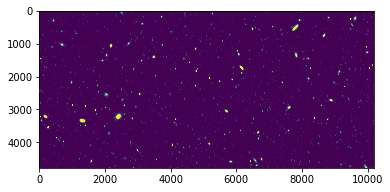

In [157]:
sky1 = SkyCoord(str(53.165)+"d "+str(-27.835)+"d")
x1, y1 = w.world_to_pixel(sky1)

sky2 = SkyCoord(str(53.21)+"d "+str(-27.75)+"d")
x2, y2 = w.world_to_pixel(sky2)

# plt.ylim(x1,x2)
# plt.xlim(y1,y2)

plt.imshow(data3[int(x2):int(x1),int(y1):int(y2)], vmin=0, vmax=.1)

In [160]:
image = data3[int(x2):int(x1),int(y1):int(y2)]
image.shape

(4779, 10199)